In [1]:
import networkx as nx
import scipy.stats as sp
import scipy.special as spp
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import igraph as ig
import powerlaw
import mpmath
from itertools import product
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
!pip install python-pptx

In [2]:
def get_colours(graph) -> list:
    from pptx.dml.color import RGBColor
    out = list(dict(graph.nodes.data('color')).values())
    out = list(map(lambda x: x[4:-1], out))
    out = list(map(lambda x: x.split(','), out))
    out = list(map(lambda x: list(map(float, x)),out))
    out = list(map(lambda x: np.array(x)/255, out))
    return out

In [3]:
def encoded_classes(graph):
    cc, _ = get_sorted_freq(graph)
    values = list(dict(graph.nodes.data('disclass')).values())
    encoded_classes = {v: i for i, v in enumerate(cc)}
    results = {i: encoded_classes[v] for i, v in enumerate(values)}
    return {'encoded_class': results}

In [4]:
def get_sizes(graph) -> list:
    return list(np.array(list(dict(graph.nodes.data('size')).values()))*6)

In [5]:
def get_positions(graph) -> dict:
    positions = {}
    for p in dict(graph.nodes.data()):
        positions[p] = tuple([float(y) for y in graph.nodes.data()[p]['position'][1:-1].split(',')])
    return positions

In [6]:
def get_sorted_freq(graph):
    classes = list(dict(graph.nodes.data('disclass')).values())
    sorted_classes = dict(sorted(Counter(classes).items(), key=lambda x: x[1], reverse=True))
    return list(sorted_classes.keys()), list(sorted_classes.values())

In [7]:
def create_subgraph(graph, classes: list):
    return graph.subgraph(get_subgraph_nodes(graph, classes))

In [8]:
def get_subgraph_nodes(graph, classes: list):
    classes = set(classes)
    graph_nodes = dict(graph.nodes.data('disclass'))
    nodes_wanted = [k for k,v in graph_nodes.items() if graph_nodes[k] in classes]
        
    return nodes_wanted

In [9]:
def get_densities(graph, num_ps):
    classes, _ = get_sorted_freq(graph)
    combinations = list(product(classes, classes))
    probs = []

    for c in combinations:

        class1 = c[0]
        class2 = c[1]
        
        nodes1 = get_subgraph_nodes(graph, [class1])
        nodes2 = get_subgraph_nodes(graph, [class2])
        
        sub = create_subgraph(graph, [class1, class2])
        sub_edges = set(list(sub.edges()))
        
        sub_nodes_combs1 = list(product(nodes1, nodes2))
        sub_nodes_combs2 = list(product(nodes2, nodes1))
        sub_nodes_combs = sub_nodes_combs1 + sub_nodes_combs2
        
        num_inter_links = len(set(sub_nodes_combs).intersection(sub_edges))
        
        probs.append(num_inter_links)

    probs = np.array(probs).reshape(-1, num_ps) 
    probs_diagsum = np.sum(np.diagonal(probs))
    probs = probs / probs_diagsum

    return probs

In [10]:
K = ig.Graph.Read_GML('human-disease.gml')

In [11]:
pp =  K.to_networkx()

In [12]:
pp.nodes()[0]

{'id': 0.0,
 'name': '30',
 'color': 'rgb(238, 68, 68)',
 'disclass': 'Neurological',
 'label': 'Alzheimer disease',
 'position': '(-116.486664, -95.29654)',
 'type': 'disease',
 'size': 17.46866}

In [13]:
len(pp.nodes())

516

#### All Classes:

In [14]:
classes = list(dict(pp.nodes.data('disclass')).values())
print('Classes:')
print()
for c in set(classes):
    print(f'   - {c}')
print()
print('Number of classes:', len(set(classes)))

Classes:

   - Ophthamological
   - Psychiatric
   - Renal
   - Skeletal
   - Respiratory
   - Metabolic
   - Immunological
   - Connective tissue disorder
   - Muscular
   - Bone
   - Cancer
   - Developmental
   - Hematological
   - Cardiovascular
   - Gastrointestinal
   - Ear,Nose,Throat
   - Dermatological
   - Nutritional
   - Neurological
   - Unclassified
   - Multiple
   - Endocrine

Number of classes: 22


#### Number of Nodes per Class:

In [15]:
npn = Counter(classes)
s_npn = dict(sorted(npn.items(), key=lambda x: x[1], reverse=True))
for n, s in s_npn.items():
    print(f"- {n}: {s}")

- Cancer: 88
- Neurological: 55
- Multiple: 54
- Ophthamological: 39
- Hematological: 34
- Metabolic: 32
- Cardiovascular: 27
- Endocrine: 27
- Immunological: 24
- Skeletal: 23
- Dermatological: 21
- Muscular: 15
- Connective tissue disorder: 15
- Bone: 15
- Unclassified: 9
- Renal: 8
- Psychiatric: 8
- Developmental: 8
- Respiratory: 4
- Gastrointestinal: 4
- Ear,Nose,Throat: 3
- Nutritional: 3


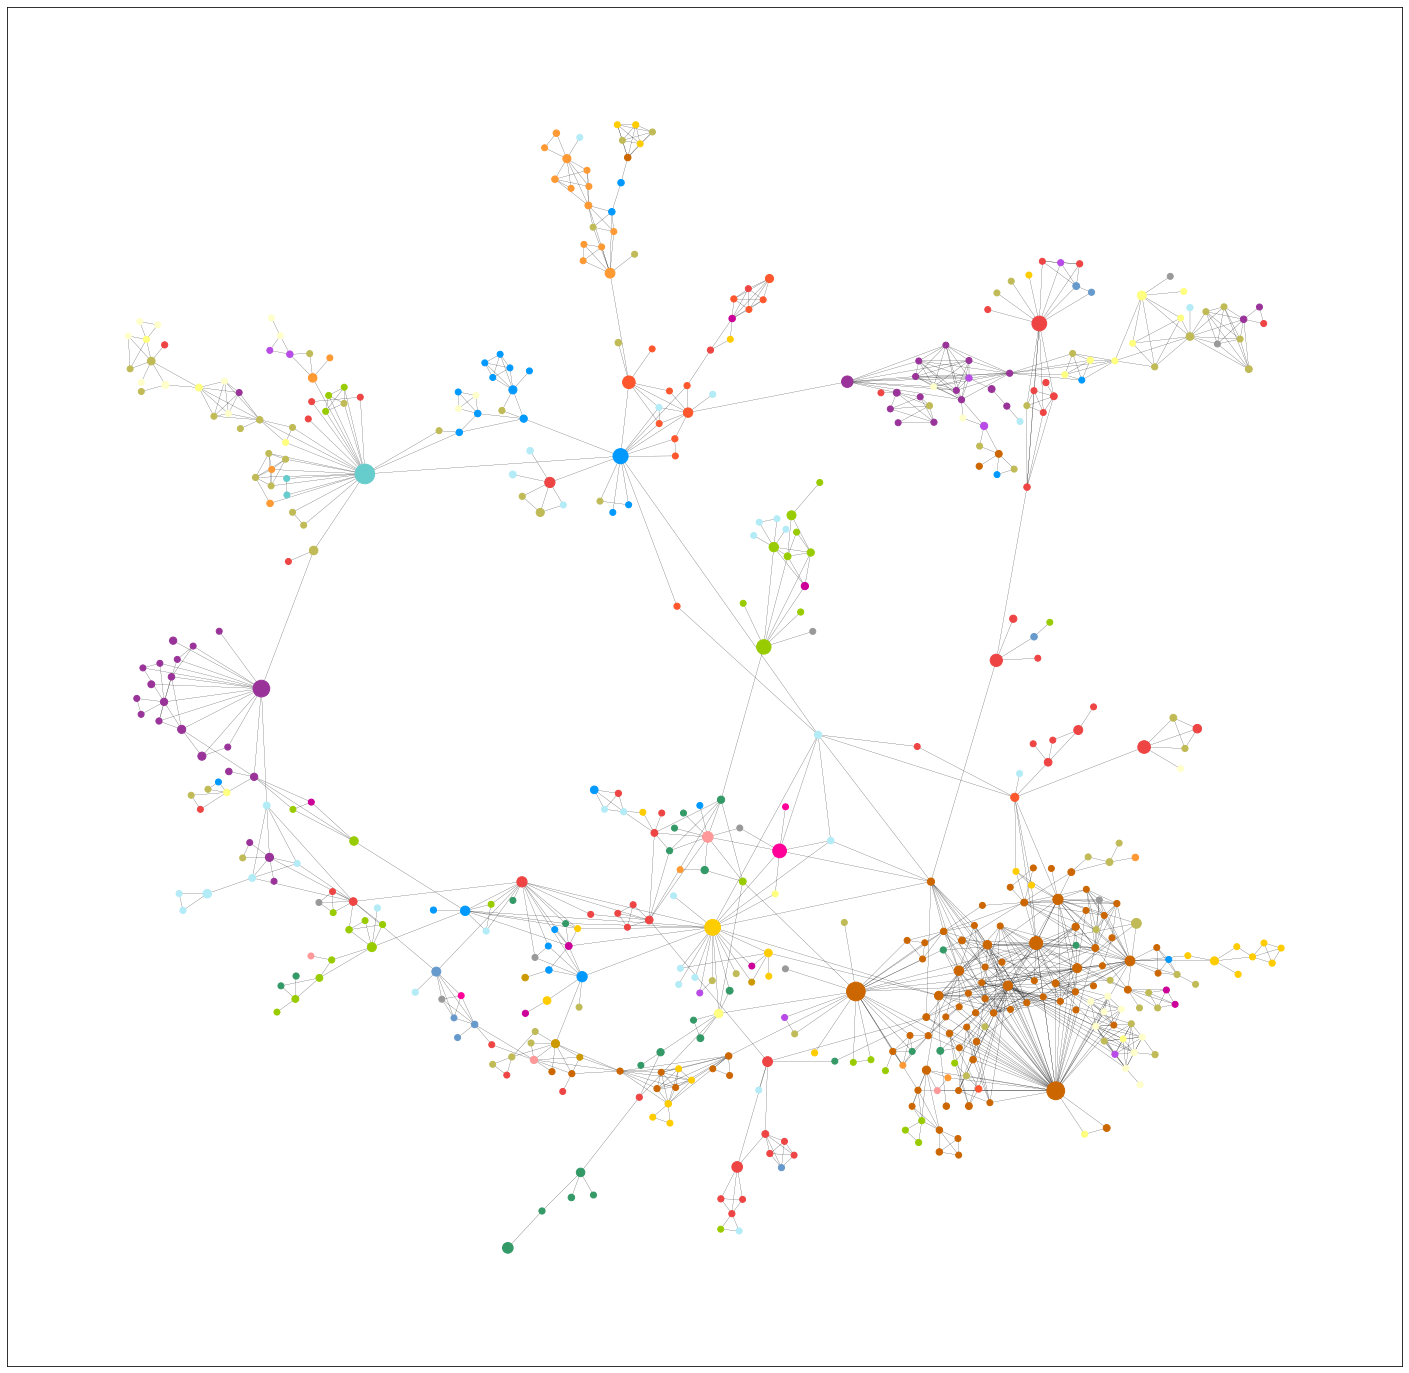

In [16]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=get_positions(pp), node_size=get_sizes(pp), with_labels=False, width=0.1)

In [18]:
new = create_subgraph(pp, ['Ear,Nose,Throat','Neurological'])

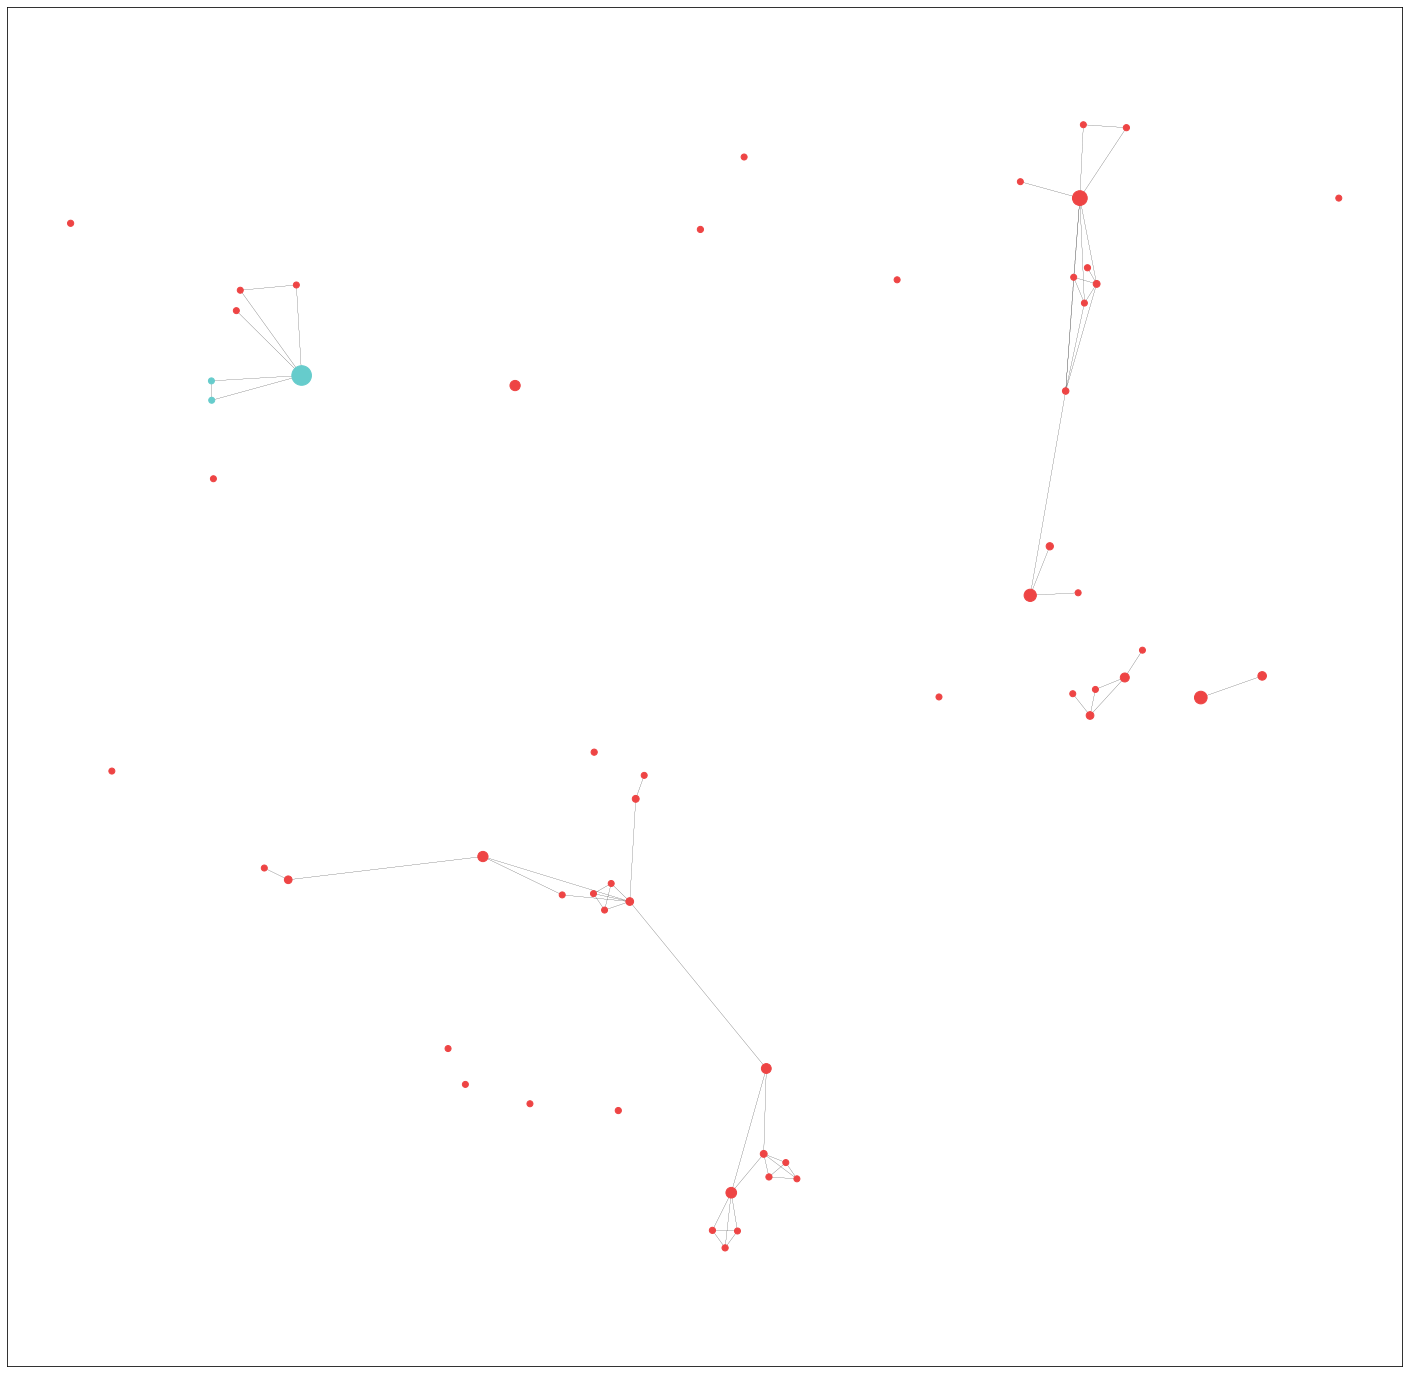

In [19]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(new, node_color=get_colours(new), pos=get_positions(new), node_size=get_sizes(new), with_labels=False, width=0.1)

In [20]:
encc = encoded_classes(pp)
nx.set_node_attributes(pp, list(encc.values())[0], list(encc.keys())[0])

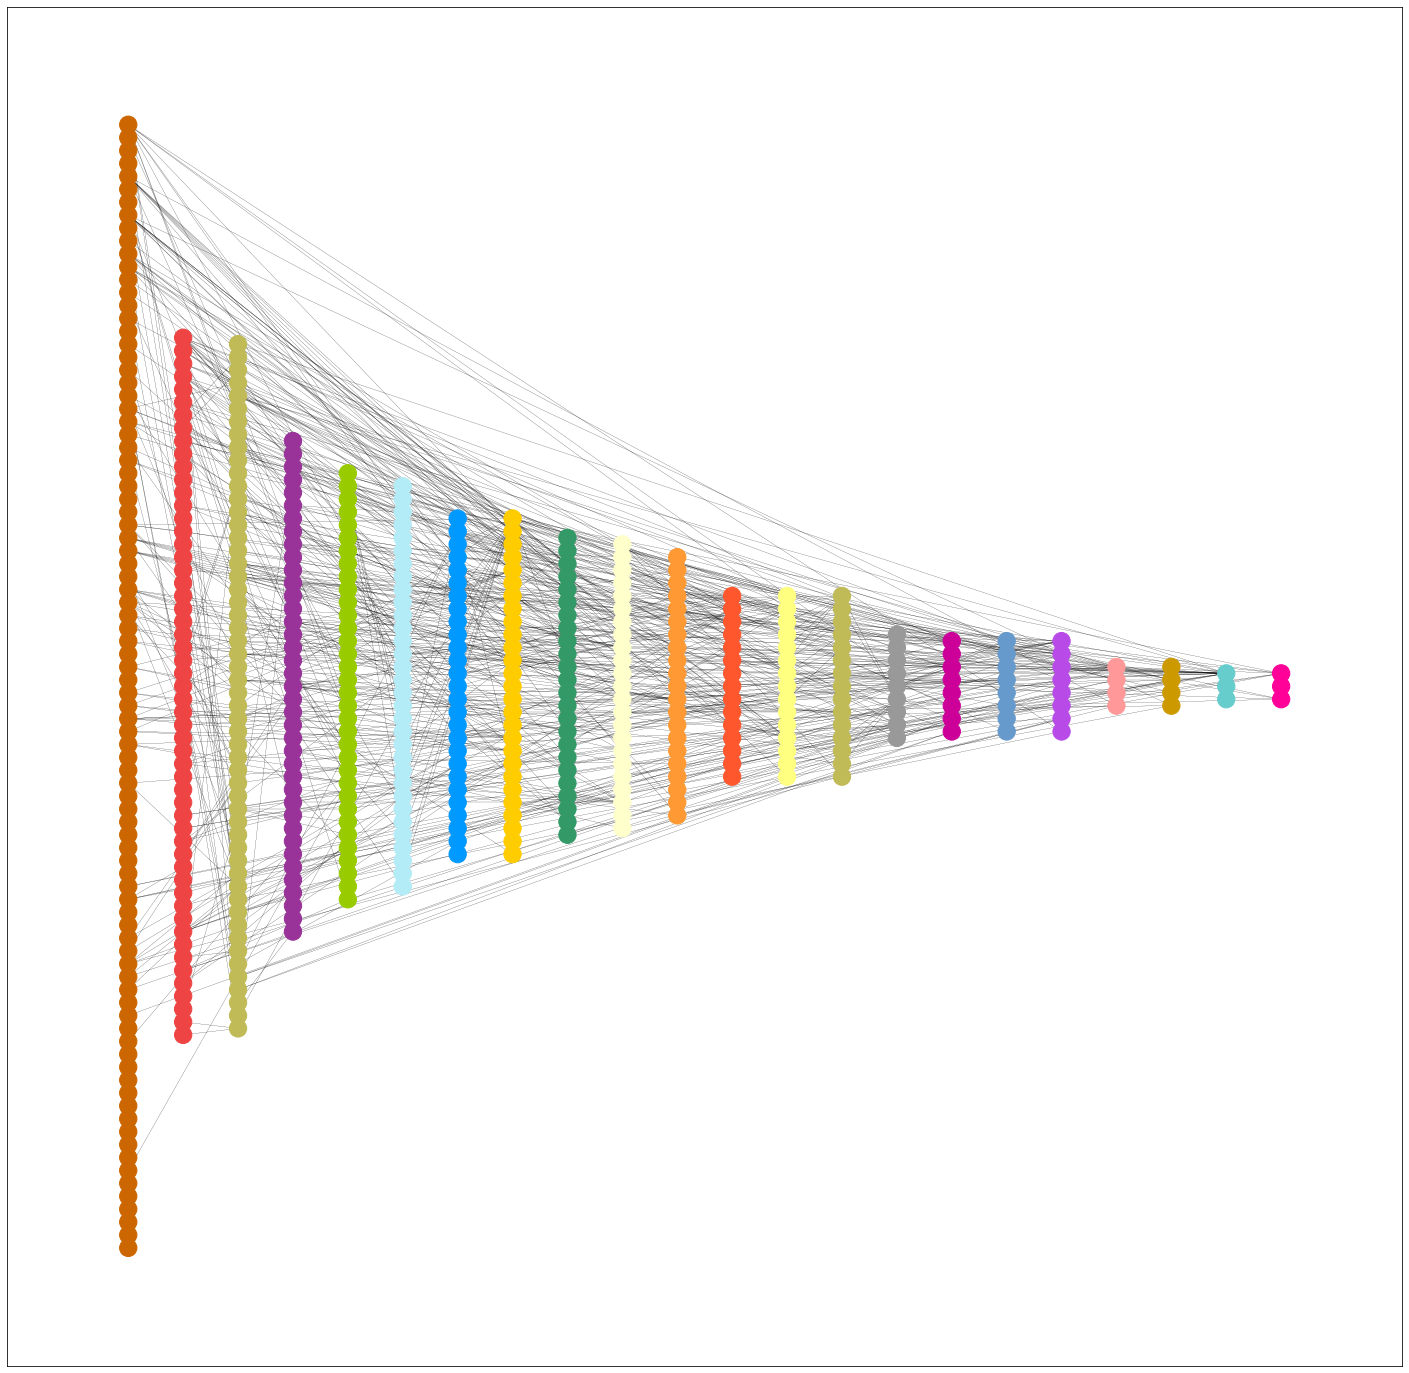

In [21]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=nx.drawing.multipartite_layout(pp, subset_key='encoded_class'), with_labels=False, width=0.1)

In [23]:
densities = get_densities(pp, len(set(classes)))
_, sizes = get_sorted_freq(pp)
rnd = nx.stochastic_block_model(sizes, densities)

In [25]:
np.sum(np.diagonal(densities))

0.9999999999999999

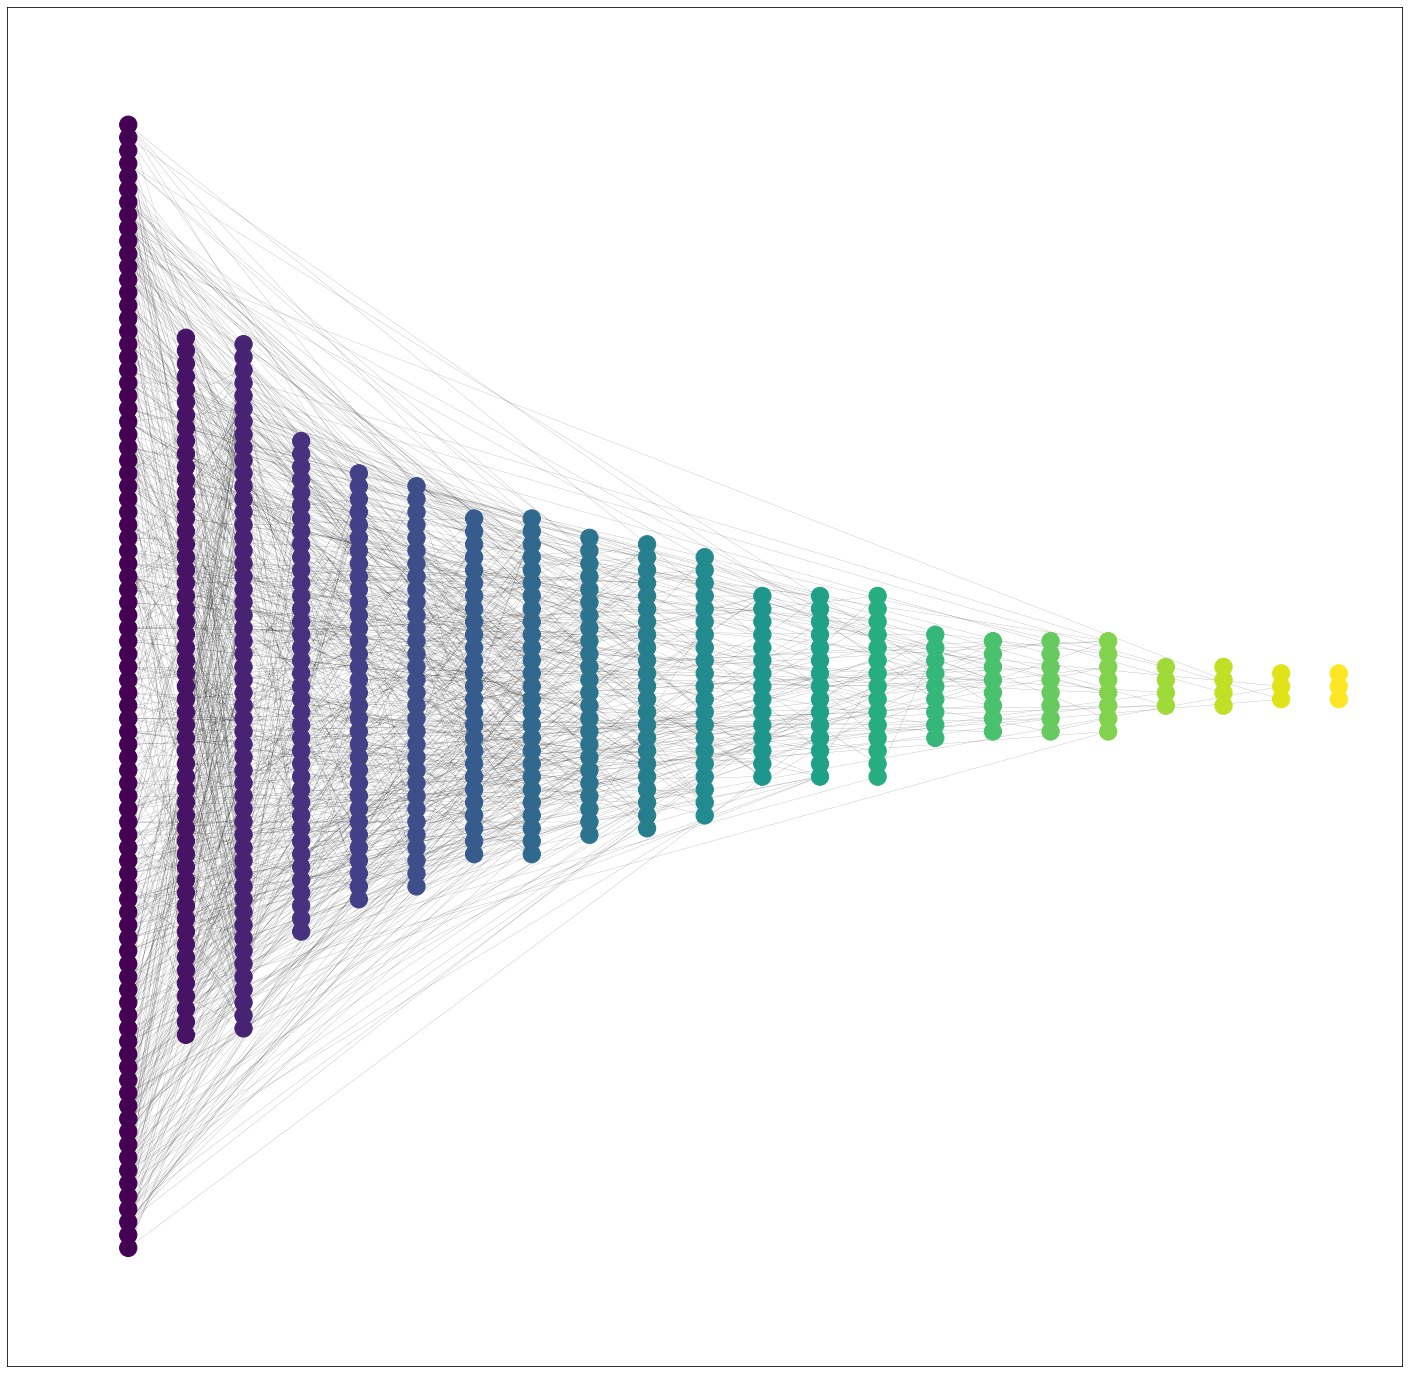

In [24]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(rnd, node_color=list(np.array(list(dict(rnd.nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(rnd, subset_key='block'), with_labels=False, width=0.1)